## This notebook is to empirically verify that the point obtaining the VaR of Chebyshev
 scalarization is a point from the MVaR set.

The result holds up. Just need to define both VaR and MVaR for maximization.

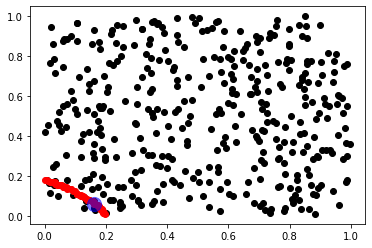

In [1]:
import torch
from botorch.acquisition.multi_objective.multi_output_risk_measures import MVaR
import matplotlib.pyplot as plt

n_w, alpha = 400, 0.8
Y = torch.rand(n_w, 2)
mvar = MVaR(n_w=n_w, alpha=alpha)
mvar_set = mvar(Y)

w_raw = torch.rand(2)
w = w_raw / w_raw.sum()
scalarized_Y = (Y * w).min(dim=-1).values
sorted_Y, idx = scalarized_Y.sort(dim=-1)
scalarized_var_Y = sorted_Y[int(n_w * (1-alpha))]
unscalarized_var = scalarized_var_Y / w

plt.scatter(Y[:, 0], Y[:, 1], color="black")
plt.scatter(mvar_set[:, 0], mvar_set[:, 1], color="r")

plt.scatter(unscalarized_var[0], unscalarized_var[1], color="blue", s=200, alpha=0.5)


## Let's see if we can find a connection between derivatives.

In [2]:
from torch import Tensor
from robust_mobo.multi_objective_risk_measures import DiffMVaR


def simple_scalarization(Y: Tensor, w: Tensor) -> Tensor:
    r"""Returns Chebyshev scalarization without any normalization.

    Args:
        Y: `batch x m`-dim tensor of outcomes.
        w: `m`-dim tensor of weights.

    Returns:
        `batch x 1`-dim tensor of min_i w_i Y_i.
    """
    return torch.min(Y * w, dim=-1, keepdim=True).values


n_w = 10
alpha = 0.5
Y = torch.rand(n_w, 2)
mvar_call = DiffMVaR(n_w, alpha)
mvar_set = mvar_call(Y)

In [3]:
mvar_set

tensor([[0.4157, 0.1549],
        [0.4070, 0.1837],
        [0.3335, 0.1876],
        [0.1834, 0.5477]])

In [4]:
mvar_0 = mvar_set[0]

In [5]:
w = 1 / mvar_0
w = w / w.sum()
w

tensor([0.2715, 0.7285])

In [6]:
from botorch.acquisition.risk_measures import VaR

scalarized_Y = simple_scalarization(Y, w)
var_call = VaR(n_w=n_w, alpha=alpha)
scalarized_var = var_call(scalarized_Y)
scalarized_var, scalarized_var / w

(tensor([0.1128]), tensor([0.4157, 0.1549]))

In [7]:
from botorch.test_functions import Branin
base_func = Branin()

def eval_func(X: Tensor) -> Tensor:
    X_p = X + 0.5
    return torch.stack([base_func(X), base_func(X_p)], dim=-1)

X = torch.rand(n_w, 2, requires_grad=True)

In [8]:
Y = eval_func(X.clone())
mvar_set = mvar_call(Y)
mvar_0 = mvar_set[0]

mvar_grad = torch.autograd.grad(mvar_0.sum(), X)[0]
mvar_grad

tensor([[  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [-37.3675, -16.4575],
        [  0.0000,   0.0000]])

In [9]:
Y = eval_func(X.clone())
mvar_set = mvar_call(Y)
mvar_0 = mvar_set[0]
w = 1 / mvar_0
w = w / w.sum()
w.detach()
scalarized_Y = simple_scalarization(Y, w)
scalarized_var = var_call(scalarized_Y)

scalarized_grad = torch.autograd.grad((scalarized_var / w).sum(), X)[0]
mvar_grad, scalarized_grad

(tensor([[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [-37.3675, -16.4575],
         [  0.0000,   0.0000]]),
 tensor([[  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [-37.3675, -16.4575],
         [  0.0000,   0.0000]]))